# 네이버 검색어 트랜드

## #01. 작업준비

### 패키지 참조

In [22]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import requests
import pandas as pd
import json
from datetime import datetime as dt
# from datetime import timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
from helper import set_datetime_index, exp_timedata
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# import pyupbit


## #02. 네이버 검색어 트랜드 openapi 연동

### 접속에 필요한 정보 설정

#### API URL

In [23]:
API_URL = 'https://openapi.naver.com/v1/datalab/search'



### 발급받은 인증키

In [24]:
client_id = 'VqTW9_KhmB5W3mCHYf_M' 
client_secret = 'eqDpF2HwLw'



### 접속 객체 생성

In [25]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id":client_id,
    "X-Naver-Client-Secret":client_secret
})

### 접속시도 

#### https get 방식인경우
: session.get(API_URL,params={'a':100,'b':200})

#### https post 방식인 경우
: session.post(API_URL,data={'a':100,'b':200})

#### https post 방식이면서 파라미터를 json으로 구성하는 경우 (body 데이터 전송)
: session.post(API_URL,data=json.dum({'a':100,'b':200}))






### 전달할 검색어 구성

In [26]:
data = {
    'startDate'  :'2020-01-01', ## 2016/01/01 부터 가능
    'endDate'  :'2023-07-31',
    'timeUnit' : 'date',       ## date, week, month
    'keywordGroups':[
        {
            "groupName":'코로나',  ## 검색 주제 
            'keywords' : ['코로나','Covid19','격리','확진자'] ## 주제와 관련된 키워드들
        }
    ]
}

### 데이터 요청하기 


In [29]:
r = session.post(API_URL,data = json.dumps(data))
## 접속에 실패한 경우
if r.status_code!=200:
    # 에러코드와 에러 메세지 출력
    msg="{%d Error} %s 에러가 발생함" % (r.status_code,r.reason)
    # 에러를 강제로 생성시킴
    raise Exception(msg)
r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2020-01-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': '코로나',
   'keywords': ['코로나', 'Covid19', '격리', '확진자'],
   'data': [{'period': '2020-01-01', 'ratio': 0.00869},
    {'period': '2020-01-02', 'ratio': 0.01115},
    {'period': '2020-01-03', 'ratio': 0.01228},
    {'period': '2020-01-04', 'ratio': 0.01182},
    {'period': '2020-01-05', 'ratio': 0.0096},
    {'period': '2020-01-06', 'ratio': 0.01228},
    {'period': '2020-01-07', 'ratio': 0.01192},
    {'period': '2020-01-08', 'ratio': 0.0118},
    {'period': '2020-01-09', 'ratio': 0.05425},
    {'period': '2020-01-10', 'ratio': 0.04167},
    {'period': '2020-01-11', 'ratio': 0.01865},
    {'period': '2020-01-12', 'ratio': 0.01171},
    {'period': '2020-01-13', 'ratio': 0.01305},
    {'period': '2020-01-14', 'ratio': 0.01334},
    {'period': '2020-01-15', 'ratio': 0.01238},
    {'period': '2020-01-16', 'ratio': 0.01632},
    {'period': '2020-01-17', 'ratio': 0.01752},
    {'period': '2020-01-1

### 가져온 데이터를 데이터 프레임을 변환


In [31]:
df= pd.DataFrame(mydict['results'][0]['data'])
df.head()

,period,ratio
0,2020-01-01,0.00869
1,2020-01-02,0.01115
2,2020-01-03,0.01228
3,2020-01-04,0.01182
4,2020-01-05,0.00960


### 날짜 칼럼에 대한 형변환 및 인덱스 설정

In [33]:
df['period'] = pd.to_datetime(df['period'])
df.set_index('period',inplace=True)


KeyError: 'period'

In [34]:
df.head()

,ratio
period,
2020-01-01,0.00869
2020-01-02,0.01115
2020-01-03,0.01228
2020-01-04,0.01182
2020-01-05,0.00960


In [36]:
df.dtypes

ratio    float64
dtype: object

In [37]:
df.isnull().sum()

ratio    0
dtype: int64

In [38]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

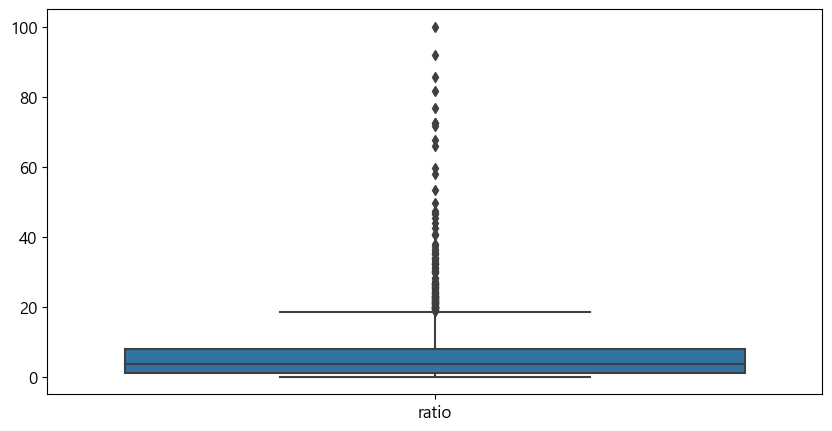

In [39]:
plt.figure()
sb.boxplot(data=df)
plt.show()
plt.close()

<Axes: xlabel='period'>

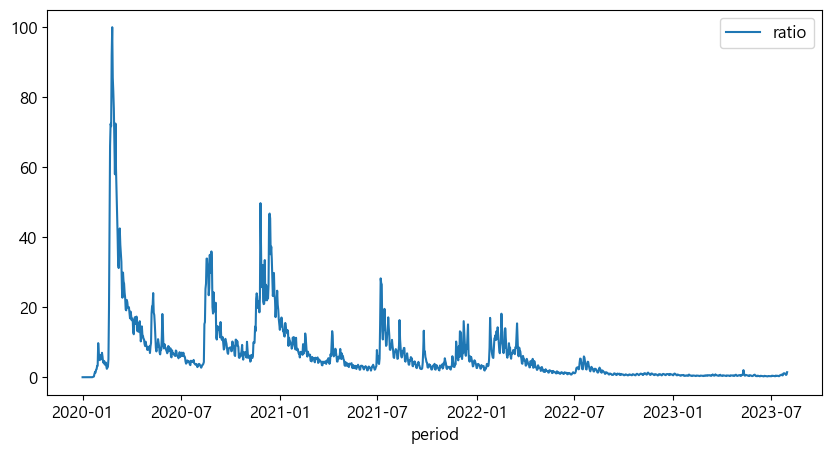

In [40]:
sb.lineplot(data=df)
## 차분 + 시계열분해

In [42]:
df.head()

,ratio
period,
2020-01-01,0.00869
2020-01-02,0.01115
2020-01-03,0.01228
2020-01-04,0.01182
2020-01-05,0.00960


### 시계열 분해


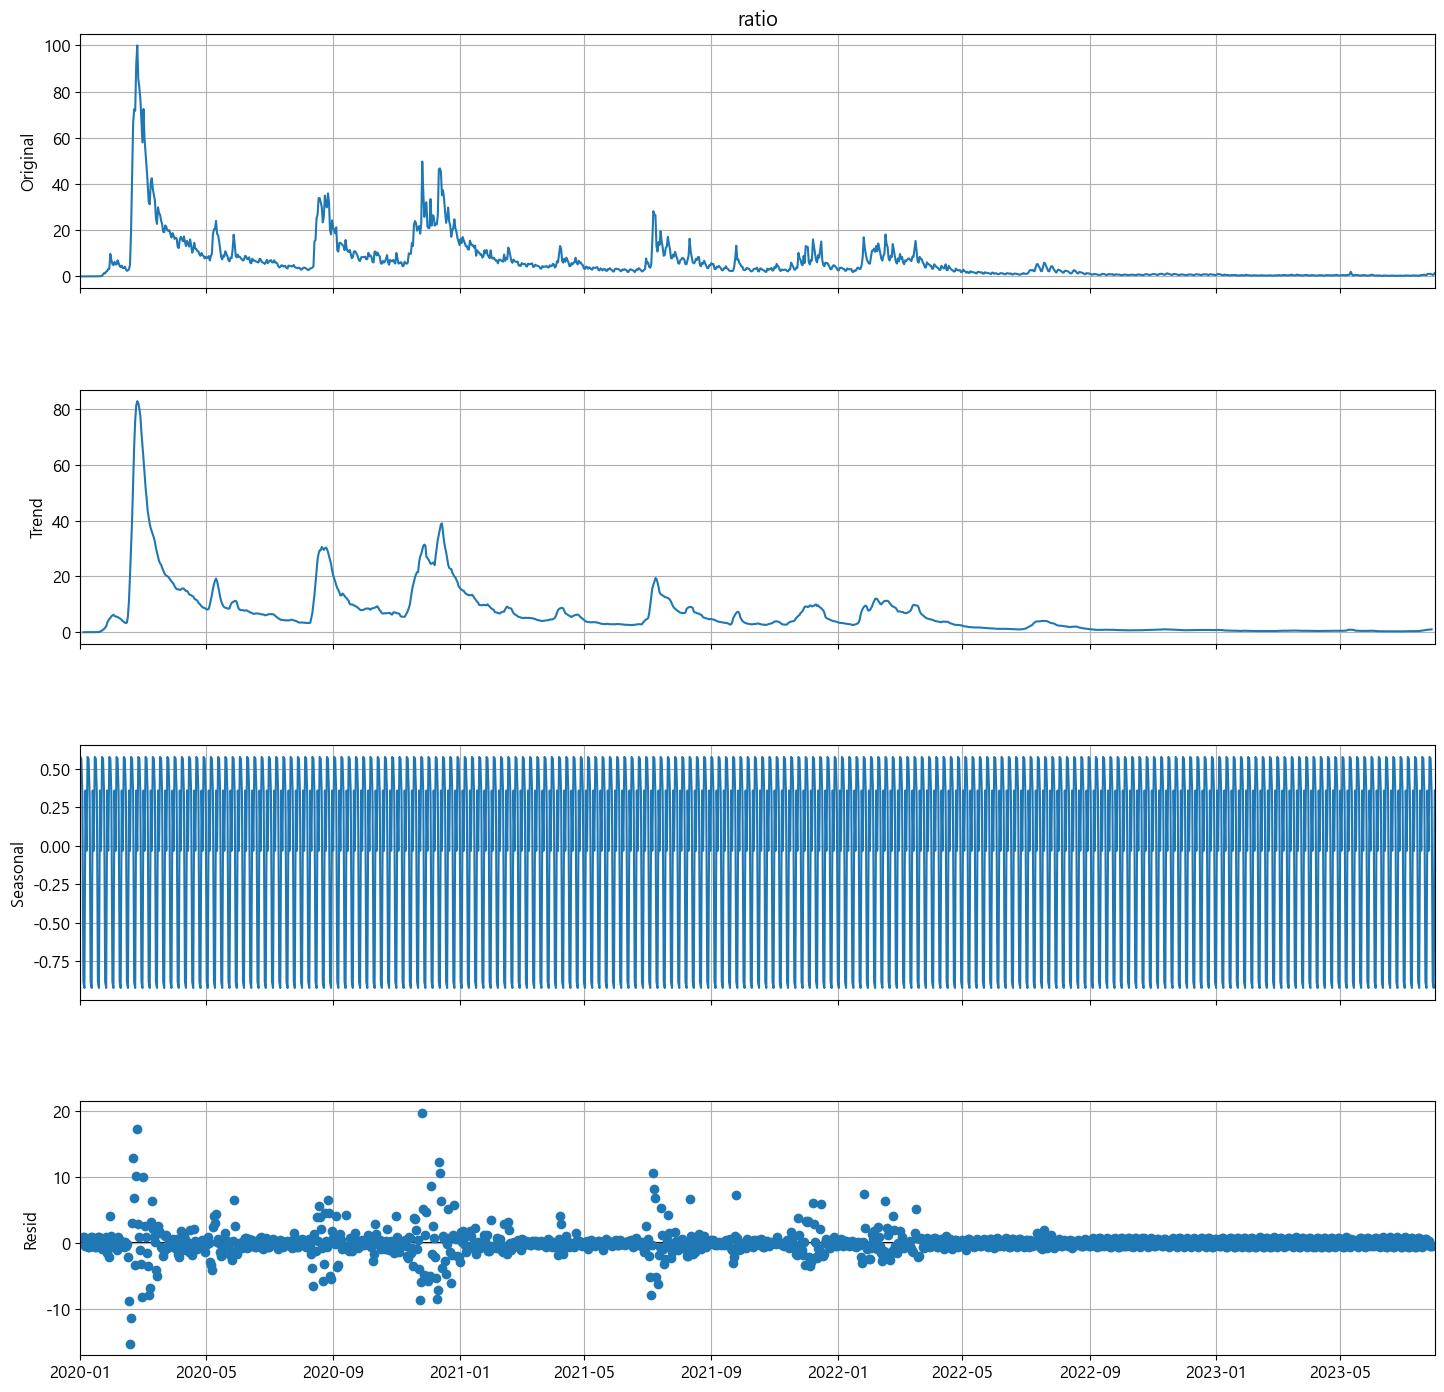

In [43]:
sd = seasonal_decompose(df['ratio'],model='Multiplicative')
figure = sd.plot()
figure.set_figwidth(15)
figure.set_figheight(16)
fig,ax1,ax2,ax3,ax4 = figure.get_children()
figure.subplots_adjust(hspace = 0.4)
ax1.set_ylabel("Original")
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

### 정상성 여부 검정



In [45]:
ar = adfuller(df)

ardict = {
        '검정통계량 (ADF Statistic) ' : [ar[0]],
        'p-value ':[ar[1]],
        '최적 차수 ':[ar[2]],
        '관측치 개수':[ar[3]]   
}

for key,value in ar[4].items():
    ardict['기각값 %s' % key] = value
         
stationality = ar[1]<0.05
ardict['데이터 정상성 여부(0=Flase,1=True)'] = stationality
ardf = pd.DataFrame(ardict,index = ['ADF']).T
ardf
   

,ADF
검정통계량 (ADF Statistic),-4.34384
p-value,0.000373
최적 차수,22
관측치 개수,1285
기각값 1%,-3.435449
기각값 5%,-2.863792
기각값 10%,-2.567969
"데이터 정상성 여부(0=Flase,1=True)",True


### 모형 결정 : ACF, PACF 테스트


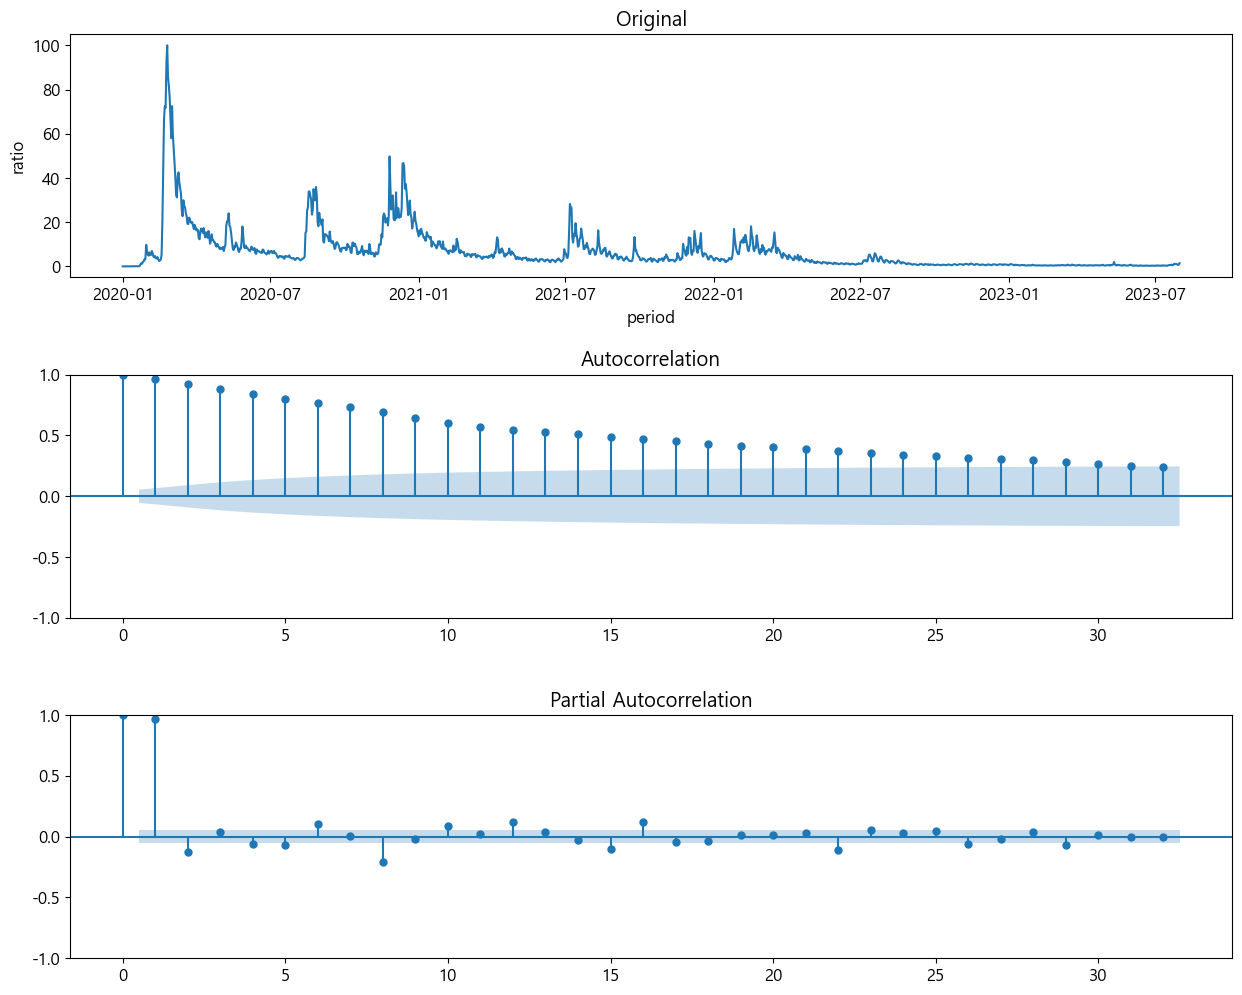

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)

ax1.title.set_text("Original")
sb.lineplot(data=df, x=df.index, y='ratio', ax=ax1)

ax2.title.set_text("ACF Test")
plot_acf(df['ratio'], ax=ax2)
        
ax3.title.set_text("PACF Test")
plot_pacf(df['ratio'], ax=ax3)
        ## acf 랑 pacf 는 따로 행한르 ㅎㅈㄷㅇ 
plt.show()
plt.close()

###  ARIMA
AR 모형 사용

In [48]:
model = ARIMA(df['ratio'],order = (2,0,0), seasonal_order=(2,0,0,7))
fit = model.fit()

print(fit.summary())

c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                           ratio   No. Observations:                 1308
Model:             ARIMA(2, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -3065.244
Date:                         Tue, 08 Aug 2023   AIC                           6142.488
Time:                                 11:35:12   BIC                           6173.546
Sample:                             01-01-2020   HQIC                          6154.138
                                  - 07-31-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6357      2.719      2.440      0.015       1.306      11.965
ar.L1          1.1050      0.008    136.947      0.000     

In [49]:
fv = fit.fittedvalues
fv.head()

period
2020-01-01    6.635671
2020-01-02    0.229892
2020-01-03    0.261775
2020-01-04    0.254720
2020-01-05    0.245797
dtype: float64

In [50]:
fc = fit.forecast(365)
fc.head()

2023-08-01    1.741220
2023-08-02    1.969412
2023-08-03    2.178280
2023-08-04    2.330041
2023-08-05    2.423117
Freq: D, Name: predicted_mean, dtype: float64

### 시각화

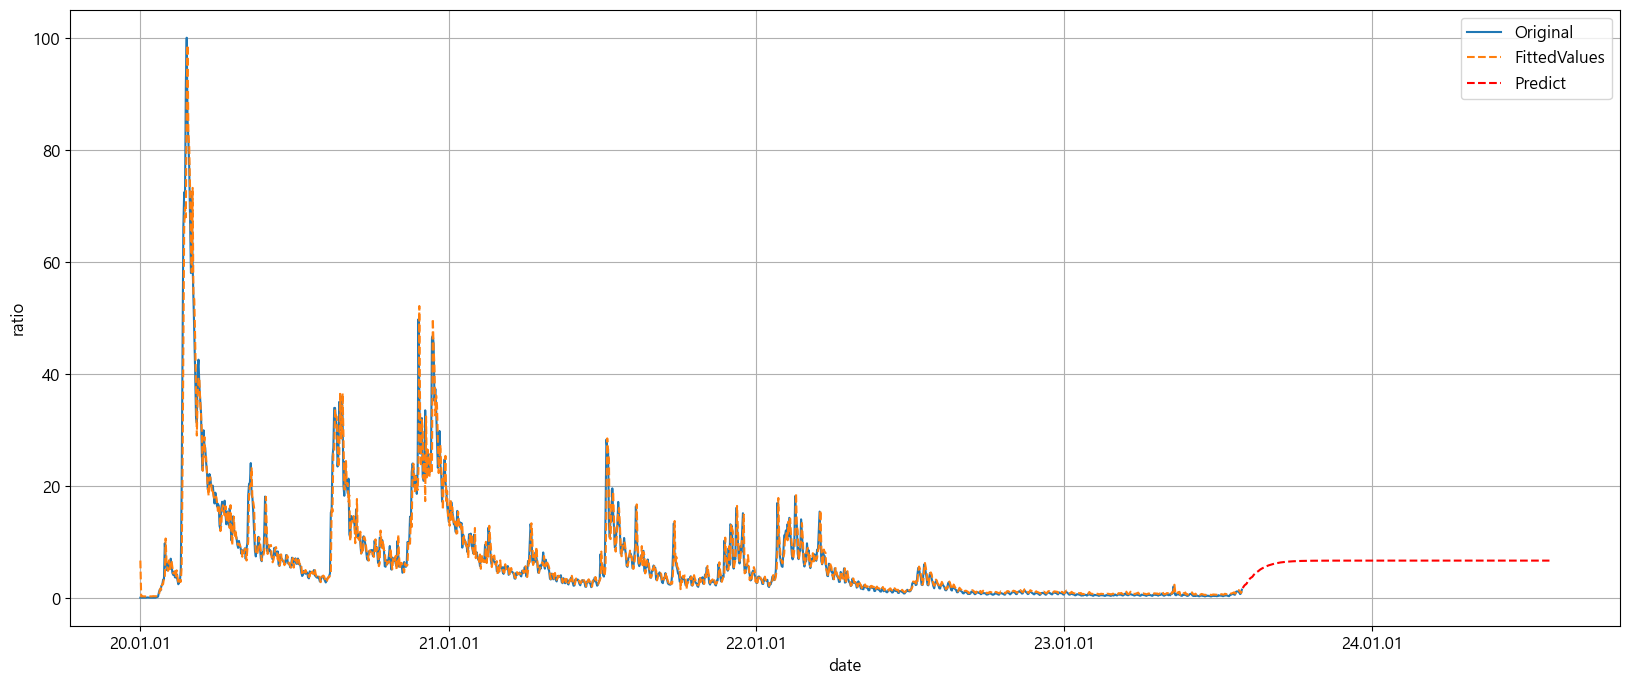

In [52]:
plt.figure(figsize=(20,8))

sb.lineplot(data=df, x=df.index, y='ratio', label='Original')
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('date')
plt.ylabel('ratio')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

### auto arima

In [54]:
my_p = 2   # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 7    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df['ratio'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,             # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=9757.648, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=6185.588, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=10246.763, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=6235.644, Time=0.22 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=6174.241, Time=2.42 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=8740.262, Time=1.37 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=6142.488, Time=2.31 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=6160.735, Time=0.87 sec
 ARIMA(2,0,0)(2,0,0)[7]             : AIC=6151.228, Time=0.92 sec

Best model:  ARIMA(2,0,0)(2,0,0)[7] intercept
Total fit time: 8.885 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1308
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -3065.244
Date:          

In [55]:
fv = model.fittedvalues()
fv.head()
fc = model.predict(365)

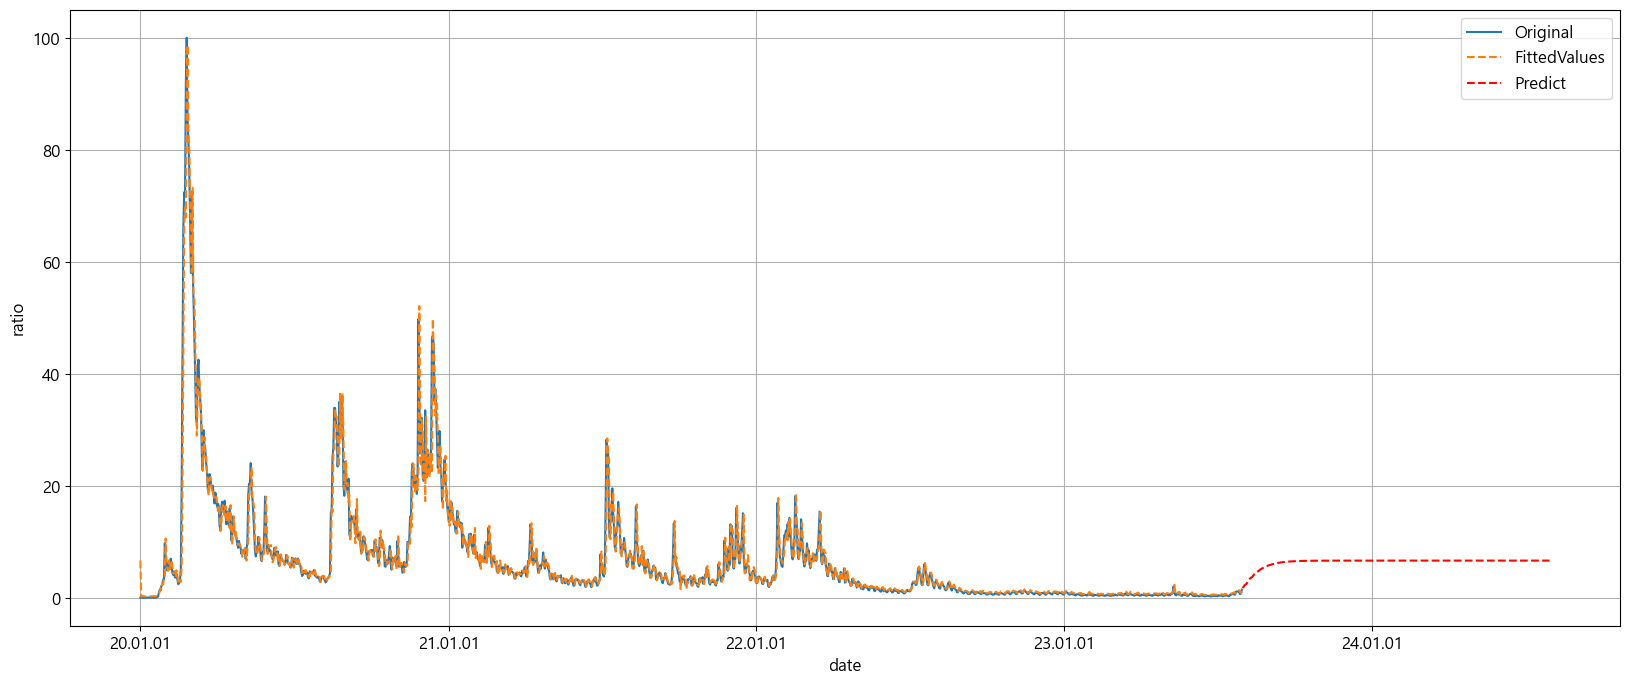

In [56]:
plt.figure(figsize=(20,8))

sb.lineplot(data=df, x=df.index, y='ratio', label='Original')
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('date')
plt.ylabel('ratio')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()